In [1]:
#####################################################################################
## We set up a pipeline for predicting the masks By using the techniques used in the 
## other notebooks
#####################################################################################

## 1> Remove black corners (optional)
## 2> Create Filters
## 3> Append the filters & mask pixels in a dataframe
## 4> Split the dataframe (50: 25: 25) - (train: validate: test) and train the model
## 5> Predict on test dataset
## 6> Run the dilation filter step


In [2]:
###### >>> POINT 2 <<<
## Filters that will be used on the train problem set to create the master dataset 
## This dataset will then be used for training a machine learning model

In [3]:
import os 

import cv2

import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility

from skimage import filters

from sklearn import svm, metrics 
from sklearn.externals import joblib

import scipy.misc
from scipy.misc import imread
import matplotlib.pyplot as plt

%matplotlib inline

In [53]:
def rgb2gray(img):
    """Convert a RGB image to gray scale."""
    return 0.2989*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]


In [18]:
def img3d2d(image, listCols):
    imgdf = pd.DataFrame(image.transpose(2,0,1).reshape(3,-1).transpose(1,0))
    imgdf.columns = listCols
    return imgdf

In [4]:
## Read the test files
ip_files = []
test_files = os.listdir('E:\\SigTuple_Hack\\Train_Data\\')
ip_files += [f for f in test_files if f.endswith('.jpg') and 'mask' not in f]

#ip_files

In [5]:
input_file = 'E:\\SigTuple_Hack\\Train_Data\\' + ip_files[5]
#filter_file = 'E:\\SigTuple_Hack\\Train_Data\\' + img_file[:-4] + '-filter0.jpg'
print input_file

E:\SigTuple_Hack\Train_Data\train-0.jpg


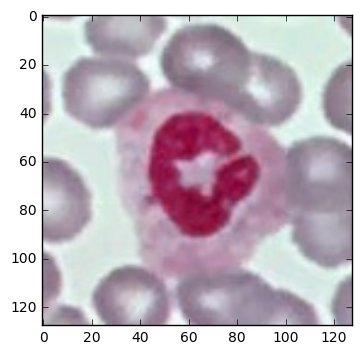

In [19]:
# Load the image 
imgcolor = cv2.imread(input_file) 
plt.imshow(imgcolor)
imageDF = img3d2d(imgcolor, ['R', 'G', 'B'])

In [20]:
# Convert BGR to HSV and gray scale image
imghsv = cv2.cvtColor(imgcolor, cv2.COLOR_BGR2HSV)
imggray = cv2.cvtColor(imgcolor, cv2.COLOR_BGR2GRAY)

imageDF = pd.concat([imageDF, img3d2d(imghsv, ['RH', 'GH', 'BH']), axis = 1)

In [23]:
imggray.shape

(128L, 128L)

In [22]:
imageDF = pd.concat([imageDF,  img3d2d(imggray, ['RG', 'GG', 'BG'])], axis = 1)

ValueError: axes don't match array

In [12]:
# Create filter with threshold using OTSU binarization
val = filters.threshold_otsu(imggray)
imgotsu = imgcolor < val

In [25]:
imageDF = pd.concat([imageDF,  img3d2d(imgotsu, ['RO', 'GO', 'BO'])], axis = 1)

In [14]:
# Create markers using watershed technique
# Create an approximate estimation of the cells by using OTSU binarization
ret, thresh = cv2.threshold(imggray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal ## >>>> Only using the noise removal on the pic with an iteration of 15 gives a 0.65
                    ## This is actually less than the one with a pure ML solution
kernel = np.ones((3,3),np.uint8)
imgopening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 15)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
 
# Finding sure foreground area
dist_transform = cv2.distanceTransform(imgopening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
    
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
imgmarkers = markers+1

# Now, mark the region of unknown with zero
imgmarkers[unknown==255] = 0

In [30]:
imgopening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 15)
imgmarkers.shape

(128L, 128L)

In [31]:
# define range of blue color in HSV
lower_wbc = np.array([120,240,150])
upper_wbc = np.array([135,255,180])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(imghsv, lower_wbc, upper_wbc)
# Bitwise-AND mask and original image
imgBlue = cv2.bitwise_and(imghsv,imghsv, mask= mask)
imgBlue.shape

(128L, 128L, 3L)

In [32]:
ret,th1 = cv2.threshold(imggray,127,255,cv2.THRESH_BINARY)
imgTh1 = cv2.bitwise_not(th1)
    
imgblur = cv2.blur(imgTh1, (10,10))
imgmedian = cv2.medianBlur(imgTh1,7)
imgbiF = cv2.bilateralFilter(imgTh1,5,75,75)    

imgblur.shape

(128L, 128L)

In [56]:
dfTrain = pd.DataFrame(columns = ['Red', 'Green', 'Blue', 'RedHSV', 'GreenHSV', 'BlueHSV',  
                                 'NoiseK', 'Markers', 'RedB', 'GreenB', 'BlueB', 'Th1', 'Blur','Median', 'BiFi' ])
for img_file in ip_files:
    input_file = 'E:\\SigTuple_Hack\\Train_Data\\' + img_file
    mask_file = 'E:\\SigTuple_Hack\\Train_Data\\' + img_file[:-4] + '-mask.jpg'
    print input_file
    
    # Load the image 
    imgcolor = cv2.imread(input_file)
    imgShape = imgcolor.shape
    
    imageDF = img3d2d(imgcolor, ['Red', 'Green', 'Blue'])
    
    
    # Convert BGR to HSV and gray scale image
    imghsv = cv2.cvtColor(imgcolor, cv2.COLOR_BGR2HSV)
    imggray = cv2.cvtColor(imgcolor, cv2.COLOR_BGR2GRAY)
    imageDF = pd.concat([imageDF ,img3d2d(imghsv, ['RedHSV', 'GreenHSV', 'BlueHSV'])], axis = 1) 
    
    # Create filter with threshold using OTSU binarization
    val = filters.threshold_otsu(imggray)
    imgotsu = imgcolor < val    
    imageDF = pd.concat([imageDF ,img3d2d(imgotsu, ['RedO', 'GreenO', 'BlueO'])], axis = 1) 
    
    # Create markers using watershed technique
    # Create an approximate estimation of the cells by using OTSU binarization
    ret, thresh = cv2.threshold(imggray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # noise removal ## >>>> Only using the noise removal on the pic with an iteration of 15 gives a 0.65
                    ## This is actually less than the one with a pure ML solution
    kernel = np.ones((3,3),np.uint8)
    imgopening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 15)
    imageDF['NoiseK'] = imgopening.reshape(imgShape[0]*imgShape[1])
    
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    imgmarkers = markers+1
    # Now, mark the region of unknown with zero
    imgmarkers[unknown==255] = 0
    
    imageDF['Markers'] = imgmarkers.reshape(imgShape[0]*imgShape[1])
    
    # define range of blue color in HSV
    lower_wbc = np.array([120,240,150])
    upper_wbc = np.array([135,255,180])
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(imghsv, lower_wbc, upper_wbc)
    # Bitwise-AND mask and original image
    imgBlue = cv2.bitwise_and(imghsv,imghsv, mask= mask)
    imageDF = pd.concat([imageDF,img3d2d(imghsv, ['RedB', 'GreenB', 'BlueB'])], axis = 1)
        
        
    ret,th1 = cv2.threshold(imggray,127,255,cv2.THRESH_BINARY)
    imgTh1 = cv2.bitwise_not(th1)
    imageDF['Th1'] = imgTh1.reshape(imgShape[0]*imgShape[1])
    
    imgblur = cv2.blur(imgTh1, (10,10))
    imgmedian = cv2.medianBlur(imgTh1,7)
    imgbiF = cv2.bilateralFilter(imgTh1,5,75,75)
    
    imageDF['Blur'] = imgblur.reshape(imgShape[0]*imgShape[1])
    imageDF['Median'] = imgmedian.reshape(imgShape[0]*imgShape[1])
    imageDF['BiFi'] = imgbiF.reshape(imgShape[0]*imgShape[1])
    
    # Inserting the mask bit
     # Load mask and append to temp df
    imgmask = cv2.imread(mask_file)/255.0
    temp = rgb2gray(imgmask)
    maskShape = temp.shape
    imageDF['Mask'] = temp.reshape(maskShape[0]*maskShape[1])
    
    dfTrain = pd.concat([dfTrain, imageDF], axis = 0)
   

E:\SigTuple_Hack\Train_Data\017532875DDF.jpg
E:\SigTuple_Hack\Train_Data\1467973104.jpg
E:\SigTuple_Hack\Train_Data\1467973122.jpg
E:\SigTuple_Hack\Train_Data\1467973178.jpg
E:\SigTuple_Hack\Train_Data\54A84627F362.jpg
E:\SigTuple_Hack\Train_Data\train-0.jpg
E:\SigTuple_Hack\Train_Data\train-1.jpg
E:\SigTuple_Hack\Train_Data\train-10.jpg
E:\SigTuple_Hack\Train_Data\train-100.jpg
E:\SigTuple_Hack\Train_Data\train-101.jpg
E:\SigTuple_Hack\Train_Data\train-102.jpg
E:\SigTuple_Hack\Train_Data\train-103.jpg
E:\SigTuple_Hack\Train_Data\train-104.jpg
E:\SigTuple_Hack\Train_Data\train-105.jpg
E:\SigTuple_Hack\Train_Data\train-106.jpg
E:\SigTuple_Hack\Train_Data\train-107.jpg
E:\SigTuple_Hack\Train_Data\train-108.jpg
E:\SigTuple_Hack\Train_Data\train-109.jpg
E:\SigTuple_Hack\Train_Data\train-11.jpg
E:\SigTuple_Hack\Train_Data\train-110.jpg
E:\SigTuple_Hack\Train_Data\train-111.jpg
E:\SigTuple_Hack\Train_Data\train-112.jpg
E:\SigTuple_Hack\Train_Data\train-113.jpg
E:\SigTuple_Hack\Train_Data\tra

In [59]:
dfTrain.columns

Index([u'BiFi', u'Blue', u'BlueB', u'BlueHSV', u'BlueO', u'Blur', u'Green',
       u'GreenB', u'GreenHSV', u'GreenO', u'Markers', u'Mask', u'Median',
       u'NoiseK', u'OTSU', u'Red', u'RedB', u'RedHSV', u'RedO', u'Th1'],
      dtype='object')

In [60]:
dfTrain.Mask[dfTrain.Mask < 0.1] = 0
dfTrain.Mask[dfTrain.Mask > 0.9] = 1

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [61]:
dfTrain.to_csv('TrainFilters.csv')